In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_04 import *

# Get data

In [3]:
x_train,y_train,x_valid,y_valid= get_data_normalized()

train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

bs,nh,c

(512, 50, 10)

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [6]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

In [7]:
learn.model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [8]:
??get_model

In [9]:
run.fit(3, learn)

train: [0.5584884765625, tensor(0.8244)]
valid: [0.732539990234375, tensor(0.7659)]
train: [0.283526171875, tensor(0.9141)]
valid: [0.62235380859375, tensor(0.8084)]
train: [0.22821720377604165, tensor(0.9311)]
valid: [0.548819091796875, tensor(0.8419)]


In [10]:
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [11]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])
run.fit(3, learn)

train: [0.6122223958333334, tensor(0.8132)]
valid: [0.7406697265625, tensor(0.7673)]
train: [0.32292301432291665, tensor(0.9029)]
valid: [0.616321044921875, tensor(0.8099)]
train: [0.2561541341145833, tensor(0.9230)]
valid: [0.57057060546875, tensor(0.8273)]


# Scheduler callback for params

In [21]:
run.epochs

3

In [22]:
run.n_epochs

2.9999999999999973

In [18]:
len(learn.opt.param_groups)

1

In [14]:
learn.opt.param_groups[0].keys() # list of params we can schedule

dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov'])

In [19]:
learn.opt.param_groups[0]['lr']

0.3

In [15]:
learn.opt.param_groups[0]['params'][0].shape

torch.Size([50, 784])

In [17]:
learn.opt.param_groups[0]['params'][1].shape

torch.Size([50])

In [24]:
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[] 

    def after_batch(self): # save learning rate (of only last groups) and loss after training each batch
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr']) # get lr of last groups and append to lrs
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups: # we could specify to have > 1 groups in pytorch opt param groups
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs) # sched_func receives a 'pos' (position)
            # e.g. train 3 epochs, at epoch 0 and 50% of the batches (self.n_epochs=0.5,self.epochs=3)
            # -> position = 0.5/3 = .16 (16% through)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

Simple linear schedule. Lr (or any params) will reach from start to end in linear rate. Form: a+ bx, with x in [0,1]

```python
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)
```

Function decorators: wrappers to existing functions, to add new functionality to existing functions

In [41]:
# example
def p_decorate(func):
    def func_wrapper(inner_name):
        return "<p>{0}</p>".format(func(inner_name))
    return func_wrapper

def div_decorate(func):
    def func_wrapper(inner_name):
        return "<div>{0}</div>".format(func(inner_name))
    return func_wrapper

@p_decorate
def get_text(name): 
    # get_text function is passed as 'func' in p_decorate
    # 'name' params is passed into func_wrapper, which is then processed by 'func' to get the lorem ipsum
    # then finally wrapped with <p> tag and return as string
    # In the end, func_wrapper is the real function that is called
    return "lorem ipsum, {0} dolor sit amet".format(name)

@div_decorate
@p_decorate
def get_text_2(name):
    return "lorem ipsum, {0} dolor sit amet".format(name)

In [44]:
get_text

<function __main__.p_decorate.<locals>.func_wrapper(inner_name)>

In [42]:
print(get_text("John"))
print(get_text_2("John"))

<p>lorem ipsum, John dolor sit amet</p>
<div><p>lorem ipsum, John dolor sit amet</p></div>


Now create a sched function with @annealer decorator

In [37]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [38]:
f = sched_lin(1,2) 
# _inner(start,end) is called, that's why we only need 2 params input (start and end)
# then it returns the partial func of sched_lin (which requires 3 param inputs) with start and end as default params input. 
# Therefore we only need to give this partial func of sched_lin the last inputs it needs: pos (b/t 0 and 1 as pct)
f(0.3)

1.3

# Different scheduler functions

Now let's add other scheduler

In [45]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

In [120]:
#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape)) # x is the torch.Tensor itself
# torch.Tensor.ndim = property(temp_func)

Wait, what is ```property```?

Syntax: property(fget, fset, fdel, doc)

Parameters:

fget() – used to get the value of attribute

fset() – used to set the value of atrribute

fdel() – used to delete the attribute value

doc() – string that contains the documentation (docstring) for the attribute

Return: Returns a property attribute from the given getter, setter and deleter.

In [121]:
temp = torch.Tensor([[1,2],[4,5],[7,8]])

In [122]:
temp.shape

torch.Size([3, 2])

In [119]:
# temp.ndim

<class 'torch.Tensor'>
tensor([[1., 2.],
        [4., 5.],
        [7., 8.]])


2

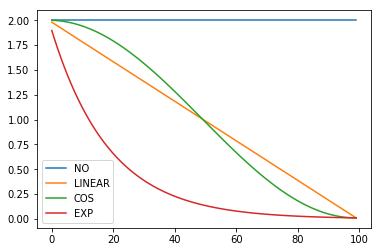

In [124]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100) # just iteration to plot
p = torch.linspace(0.01,1,100) # pos input

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

# Adding custom scheduler to combine different schedulers together

In [125]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [126]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [127]:
sched

<function __main__.combine_scheds.<locals>._inner(pos)>

In [132]:
sched(0.2)

0.5249999807287408

In [134]:
sched(0.3)

0.5999999999999992

In [131]:
sched(0.8)

0.27530203155090127

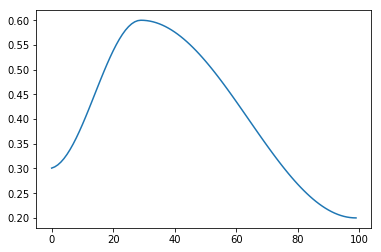

In [130]:
plt.plot(a, [sched(o) for o in p])

# Train model with lr schedule + recorder callbacks

In [143]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.8), sched_cos(0.8, 0.2)])

In [144]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [145]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [139]:
run.cbs

In [146]:
run.fit(3, learn)

train: [0.6689610677083333, tensor(0.7947)]
valid: [0.8156572265625, tensor(0.7495)]
train: [0.2799543294270833, tensor(0.9137)]
valid: [0.58595029296875, tensor(0.8186)]
train: [0.19406559244791666, tensor(0.9429)]
valid: [0.50471826171875, tensor(0.8513)]


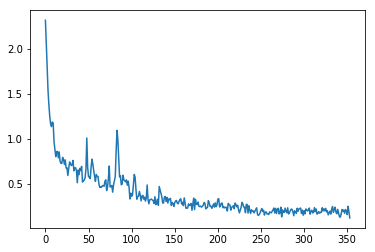

In [147]:
run.recorder.plot_loss() #validation nll loss

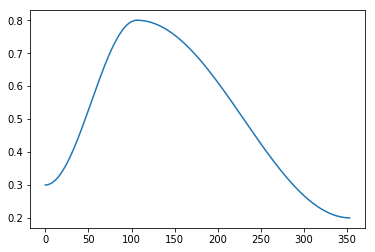

In [148]:
run.recorder.plot_lr()